# CLIP + SAM

In [18]:
#!pip3 install opencv-python
#!pip3 install segment_anything
# !pip3 install clip

In [19]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint="/workspaces/RobotLibrarian/perception/models/sam_vit_b_01ec64.pth")
#sam = sam.to("cuda")

In [21]:
predictor = SamPredictor(sam)

In [22]:
image_path = "book_and_shelf.png"
image = cv2.imread(image_path)
predictor.set_image(image)

In [23]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [24]:
image_path = "book_and_shelf.png"
image = cv2.imread(image_path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [25]:
masks = mask_generator.generate(image)

: 

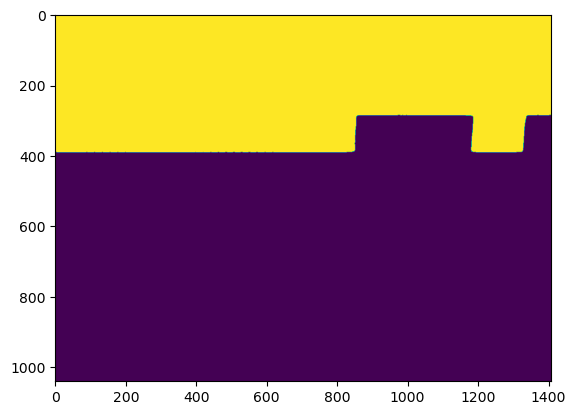

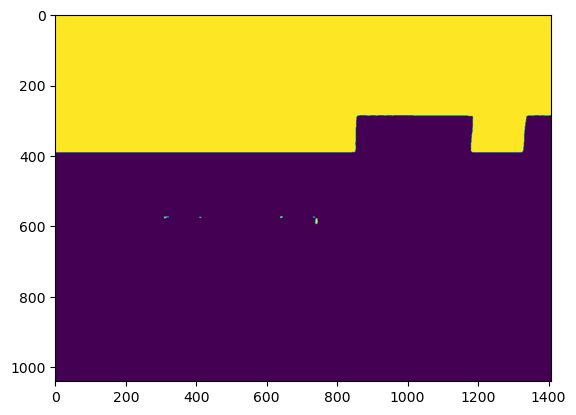

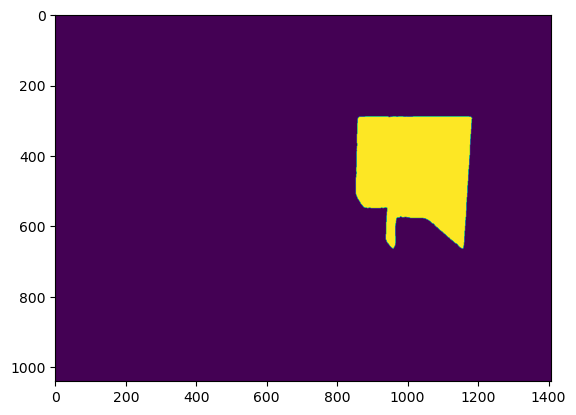

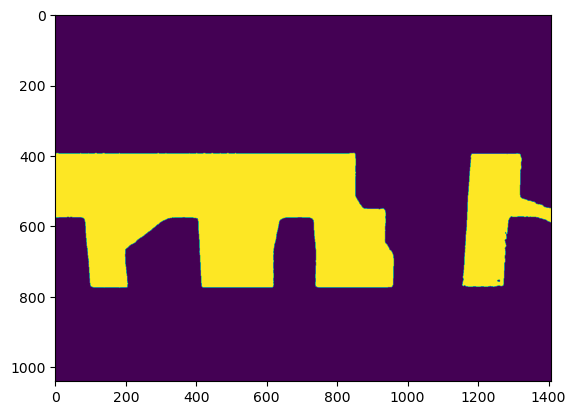

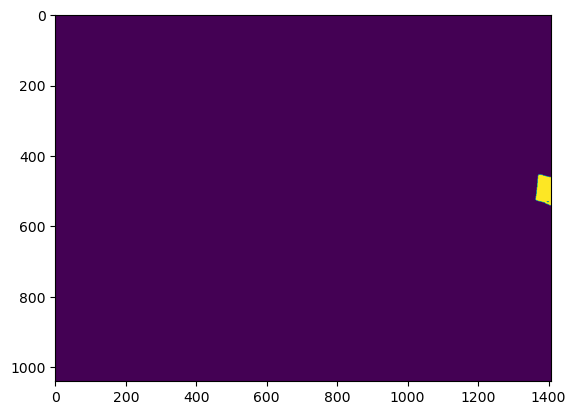

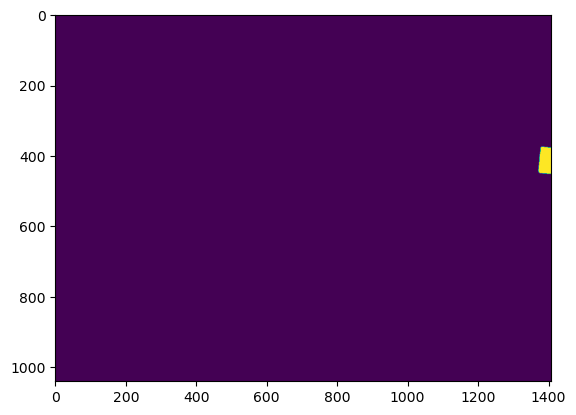

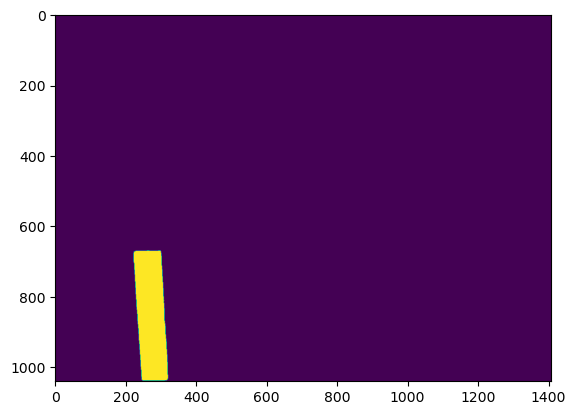

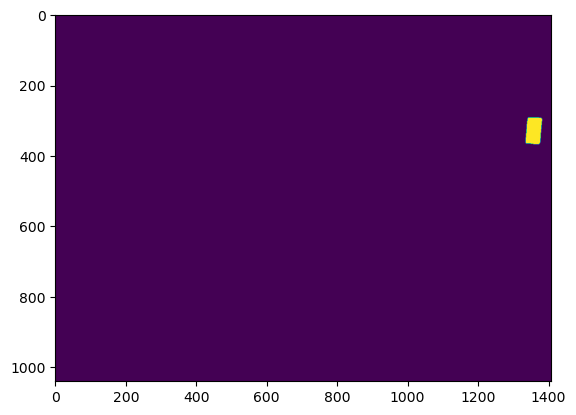

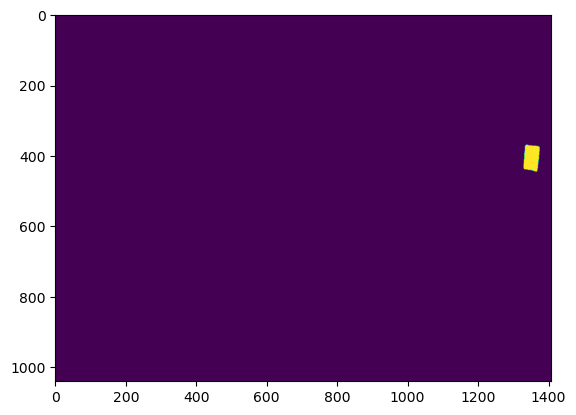

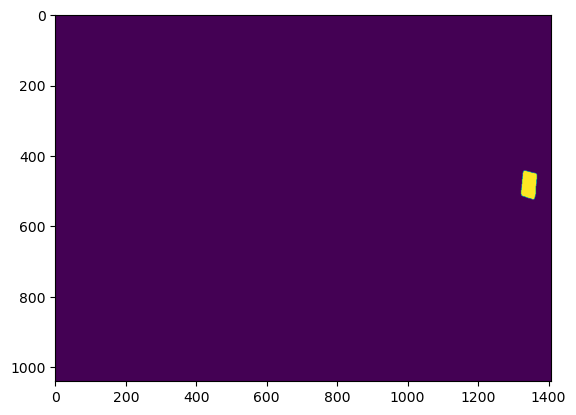

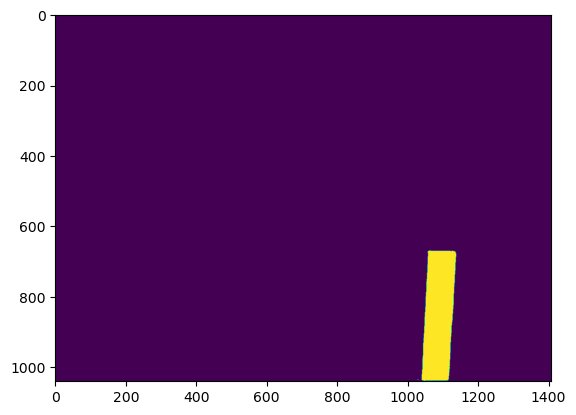

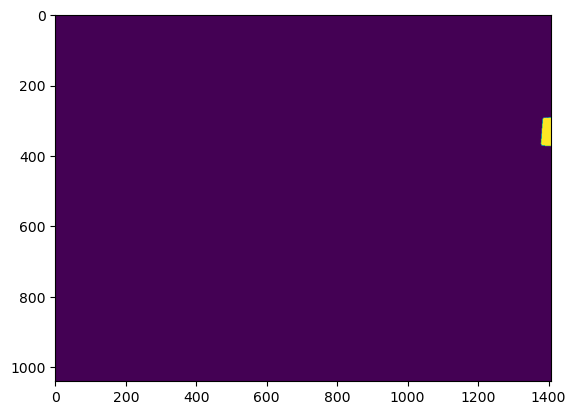

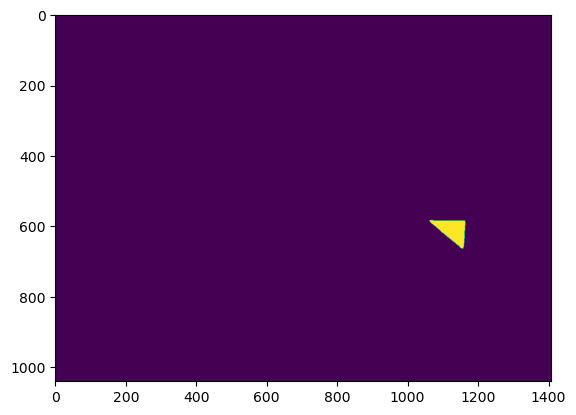

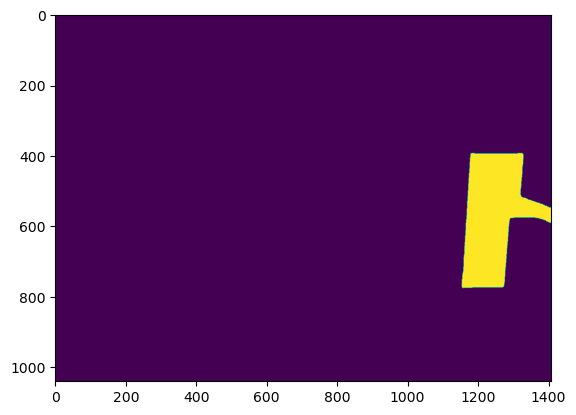

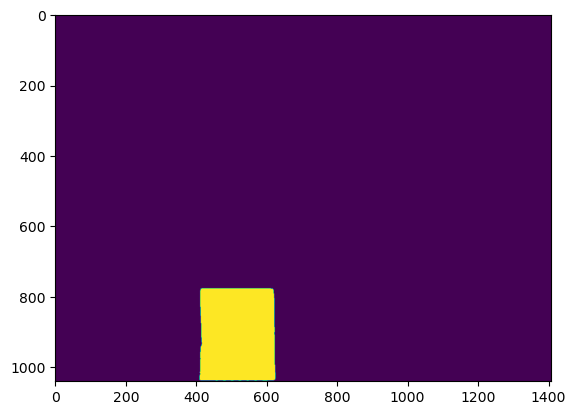

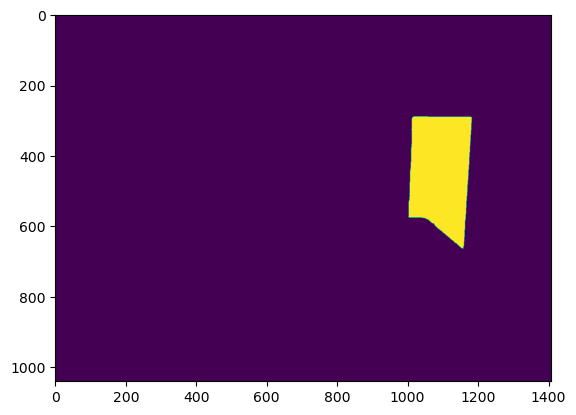

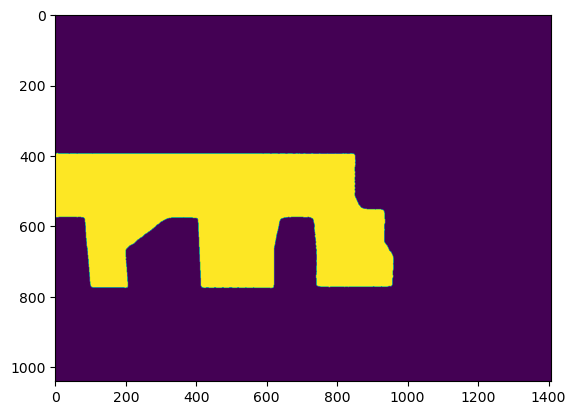

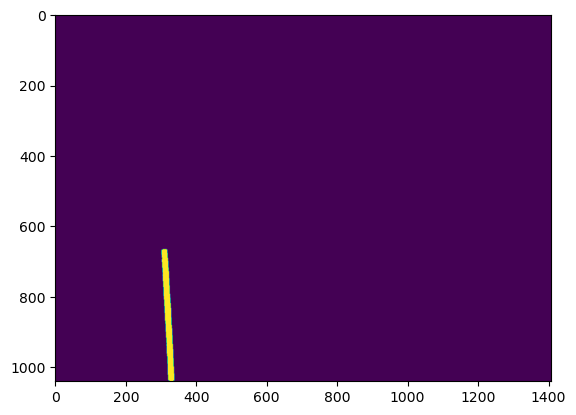

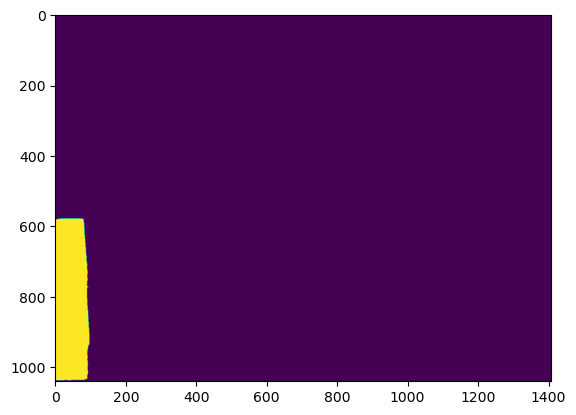

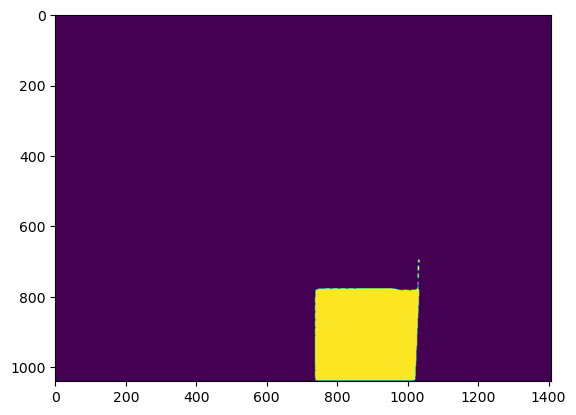

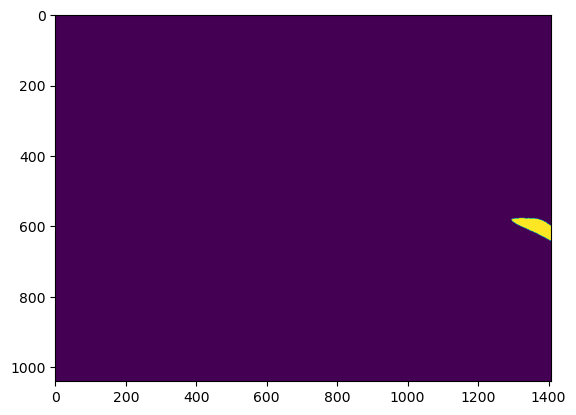

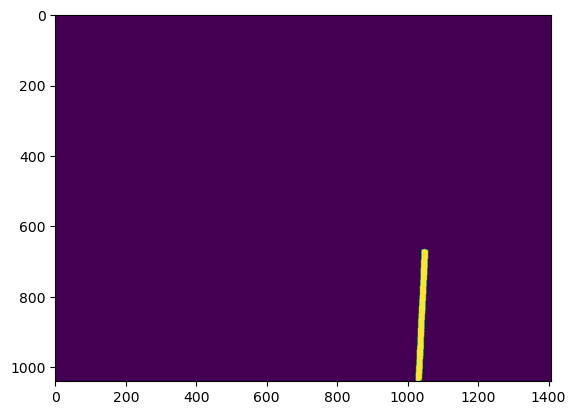

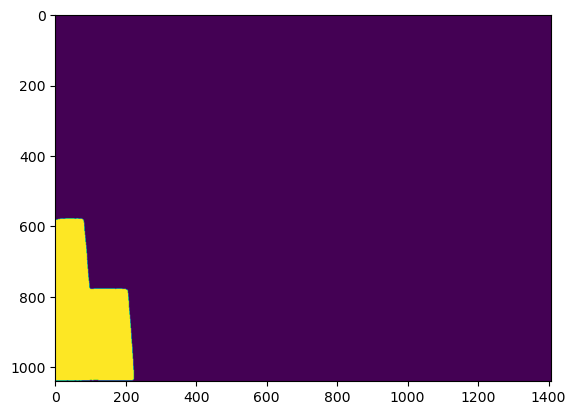

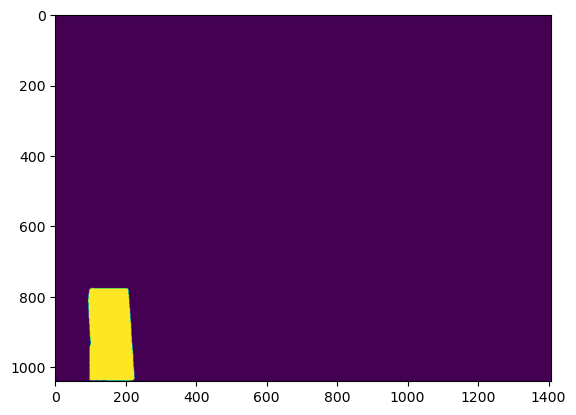

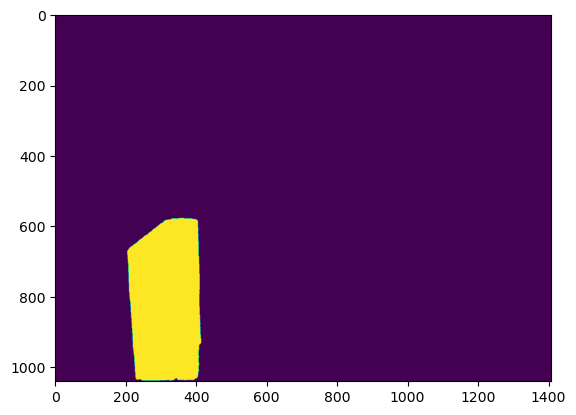

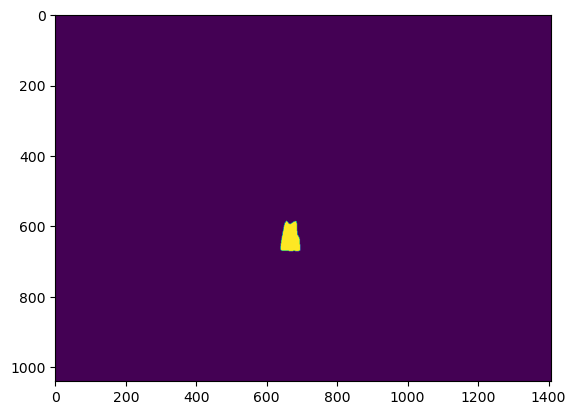

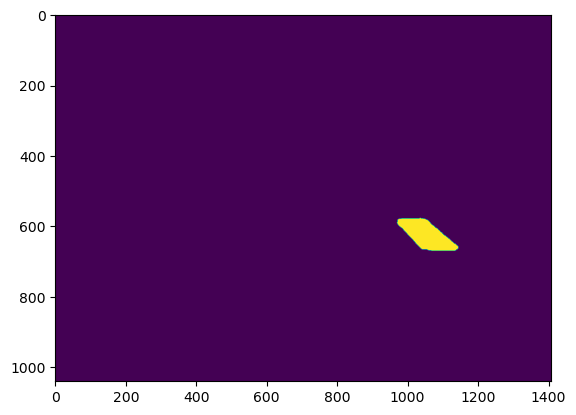

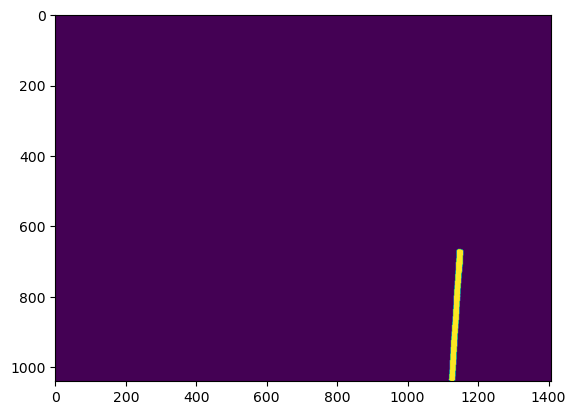

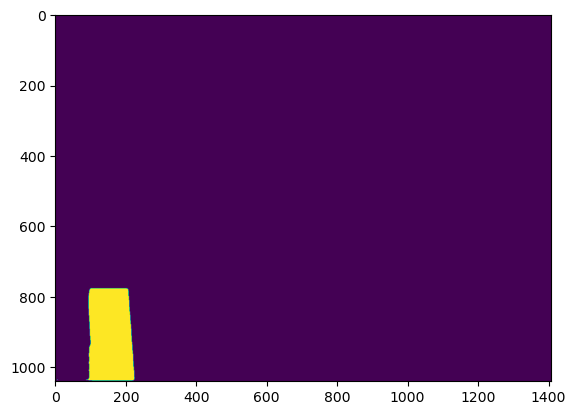

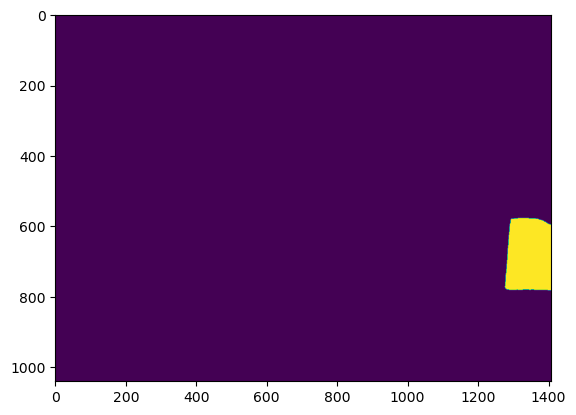

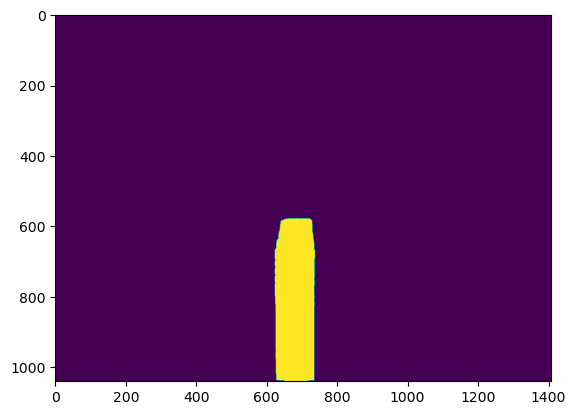

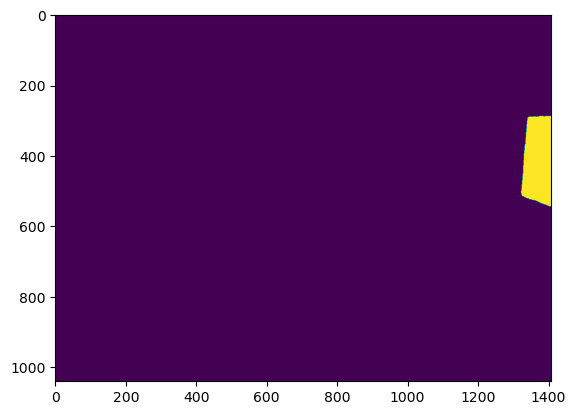

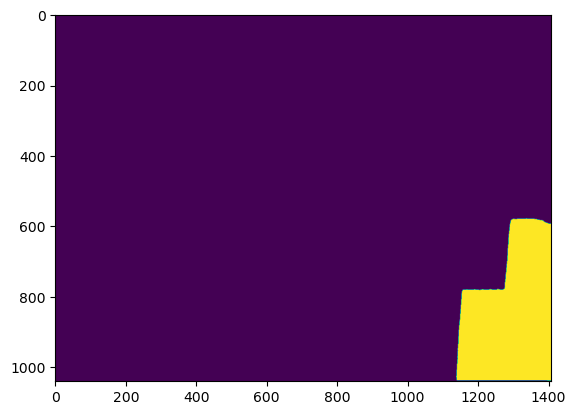

In [ ]:
for mask in masks:
    plt.imshow(mask['segmentation'])
    plt.show()

In [ ]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [ ]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [ ]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

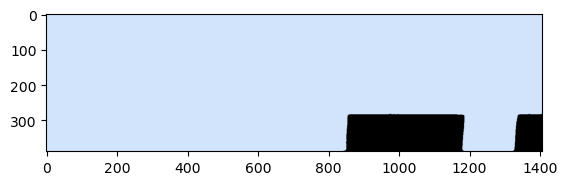

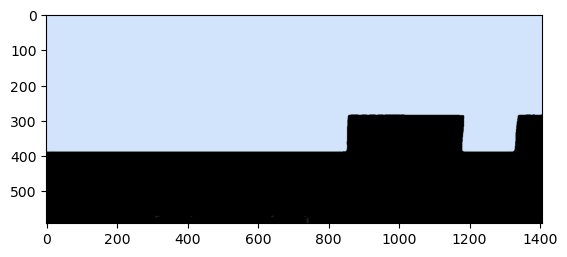

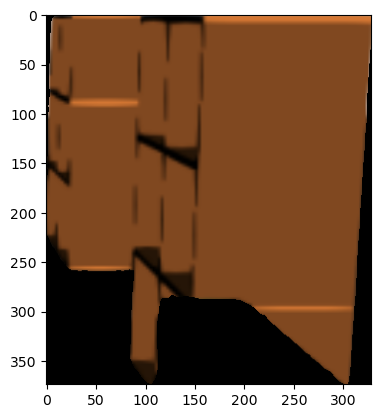

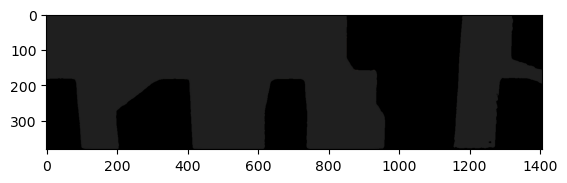

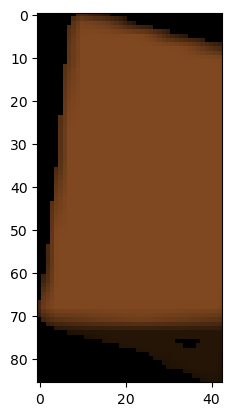

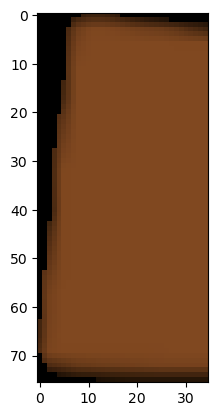

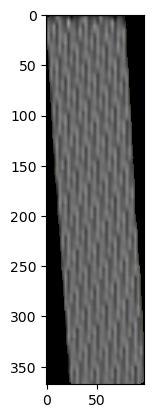

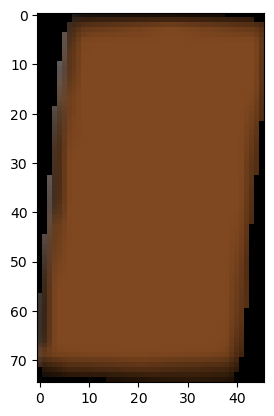

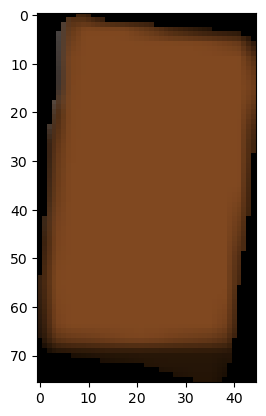

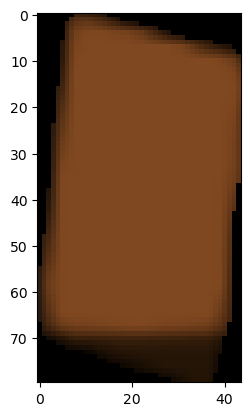

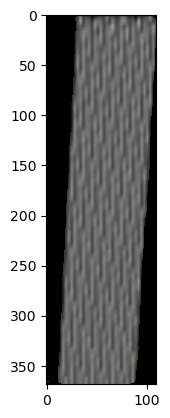

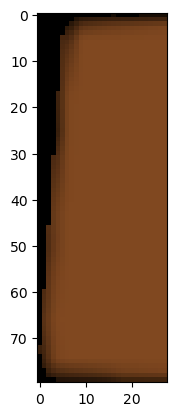

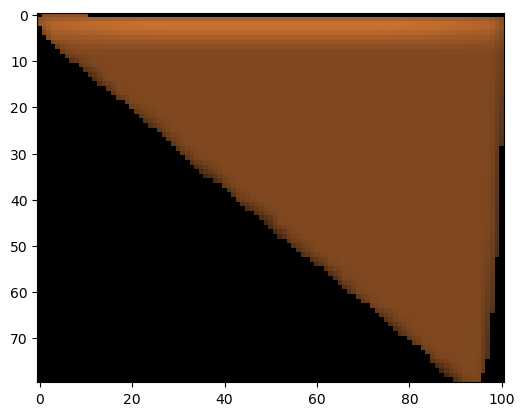

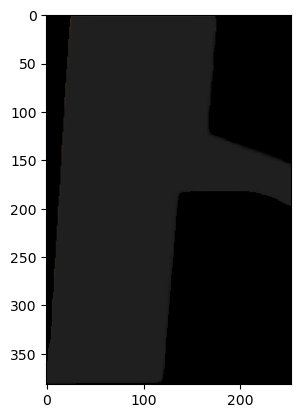

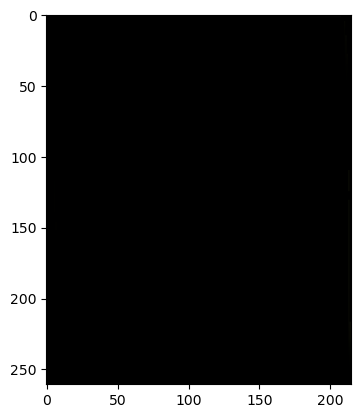

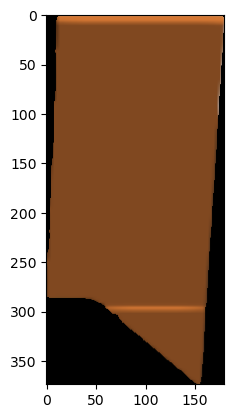

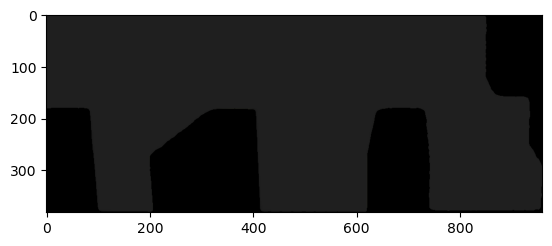

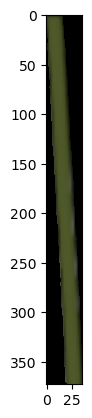

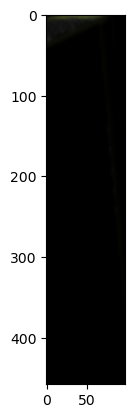

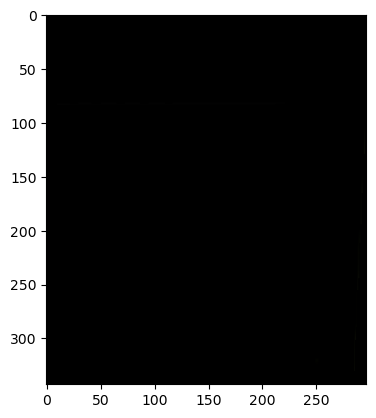

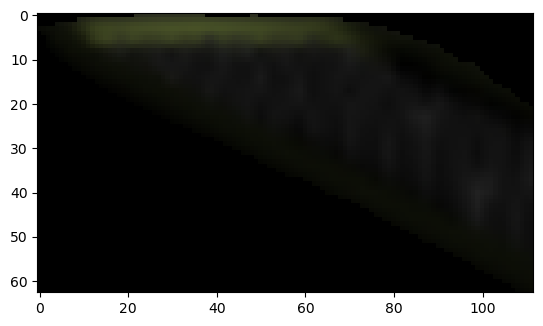

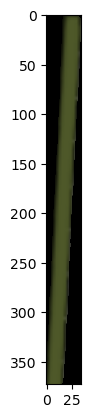

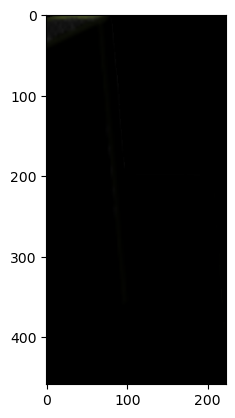

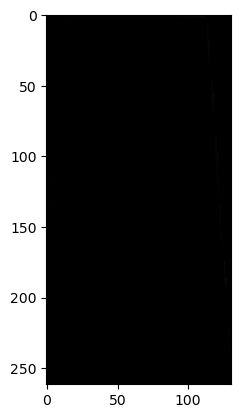

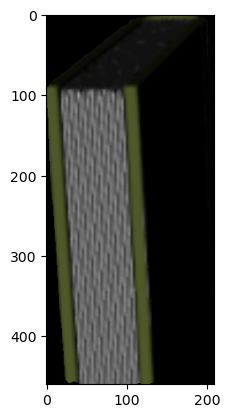

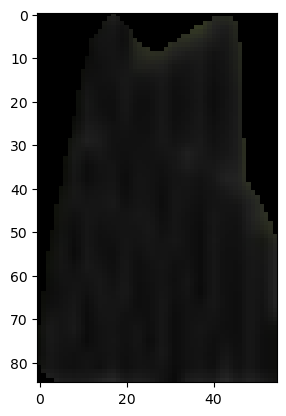

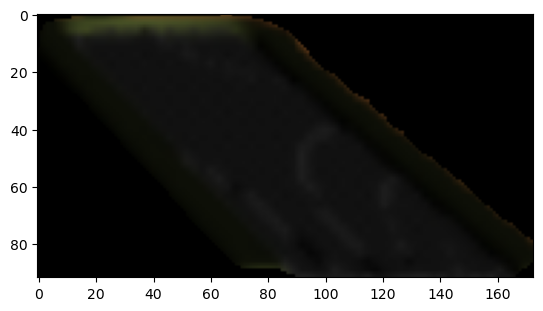

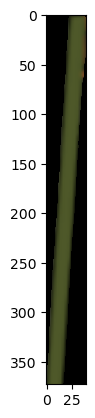

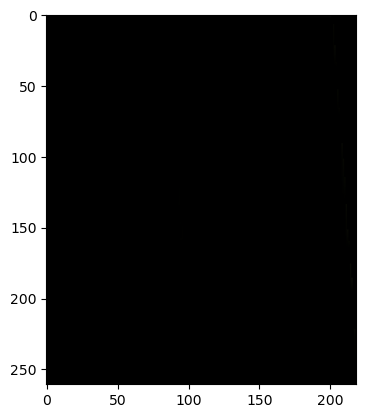

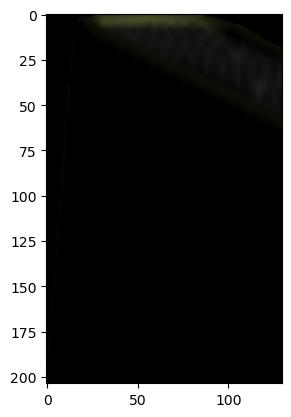

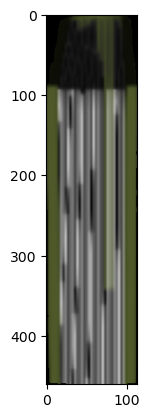

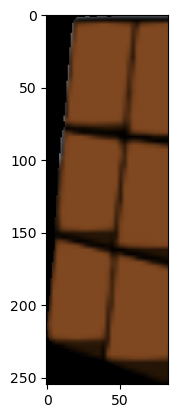

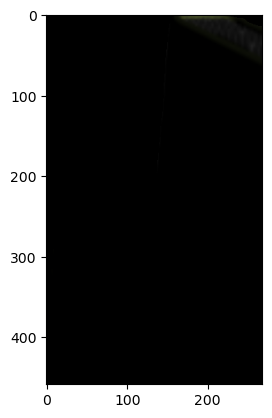

In [ ]:
for segmented_image in cropped_boxes:
    plt.imshow(segmented_image)
    plt.show()

In [ ]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [ ]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

In [ ]:
search_text = "shelves"

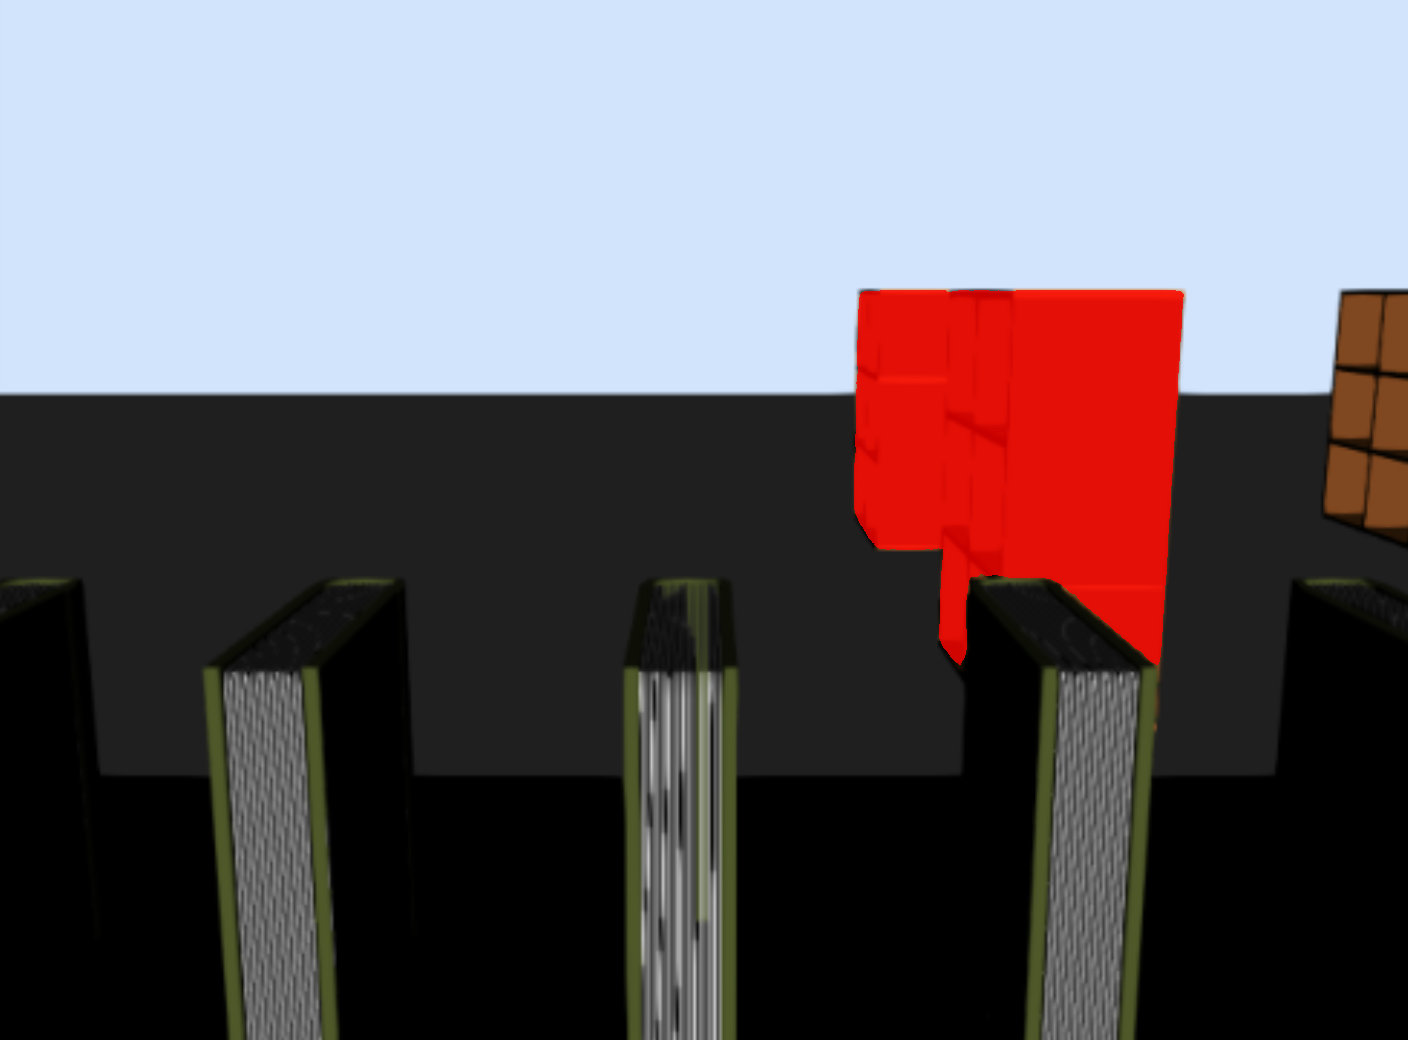

In [ ]:
scores = retriev(cropped_boxes, search_text)
indices = get_indices_of_values_above_threshold(scores, 0.05)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)

original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image